In [2]:
%%capture o
!cd build && make
## all versions can be found in the git history if you want to recompile the execs

In [3]:
import os
import subprocess
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/agardon/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [11]:
repeat = 10
dna = [500, 5000, 50000, 500000, 5000000] # -g
size = [32, 128, 256, 512]# -w -h
mut_rate = [0.0001, 0.00001, 0.000001]# -m
data = pd.DataFrame(columns=['size', 'dna_size', 'mut_rate', 'time', 'version'])


In [12]:
for s in size:
    for d in dna:
        for m in mut_rate:
            for r in range(repeat):
                args = ("./execs/micro_aevol_cpu_v0", "-g", str(d), "-w", str(s), "-h", str(s), "-r", str(r), "-m", str(m))
                time_s = time.time()
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()
                time_e = time.time() - time_s
                data.loc[len(data.index)] = [s, d, m, time_e, 'version_0']

                args = ("./execs/micro_aevol_cpu_v1", "-g", str(d), "-w", str(s), "-h", str(s), "-r", str(r), "-m", str(m))
                time_s = time.time()
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()
                time_e = time.time() - time_s
                data.loc[len(data.index)] = [s, d, m, time_e, 'version_1']
                
                args = ("./execs/micro_aevol_cpu_v2", "-g", str(d), "-w", str(s), "-h", str(s), "-r", str(r), "-m", str(m))
                time_s = time.time()
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()
                time_e = time.time() - time_s
                data.loc[len(data.index)] = [s, d, m, time_e, 'version_2']

In [13]:
data = data.astype({'size':'int','dna_size':'int'})
data.head()

,size,dna_size,mut_rate,time,version
0,32,500,0.0001,0.006843,version_0
1,32,500,0.0001,0.004716,version_1
2,32,500,0.0001,0.006135,version_2
3,32,500,0.0001,0.005560,version_0
4,32,500,0.0001,0.006033,version_1


## Improvement 1 

As a first attempt of improvement we will try to leverage SIMD instructions inside of the DNA.cpp code. Some of these methods are where major bottlenecks are found since some of these functions are called thousands of times. Each one of these functions are looking for a certain pattern in the DNA through a simple for loop which is a great candidate for the use of vectorization. To ensure these work their best, we align the array and specify this alignment in the pragma directive.

### Curiosities

A lot of the time in these loops is spent checking whether we have looped back over the start of the DNA. Trying to store the size of the DNA instead of calling .size() repeatedly was consistently about twice as slow.

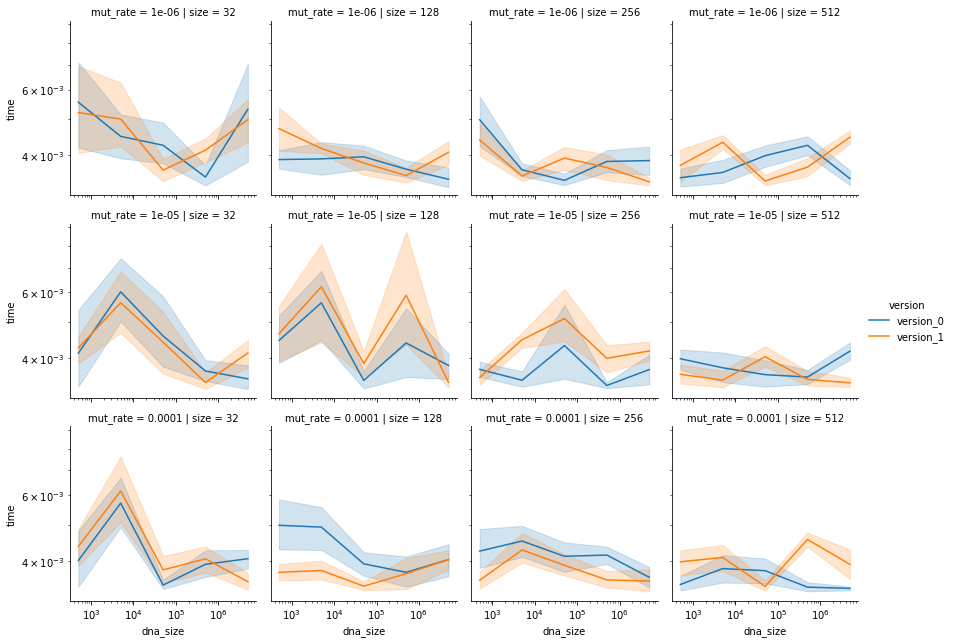

In [14]:
data_1 = data[(data['version'] == 'version_0') | (data['version'] == 'version_1')]
sea = sns.FacetGrid(data_1, col = "size", row='mut_rate', hue = "version" )
sea.map(sns.lineplot, "dna_size", "time").set(yscale='log').set(xscale='log')
sea.add_legend()

<AxesSubplot:>

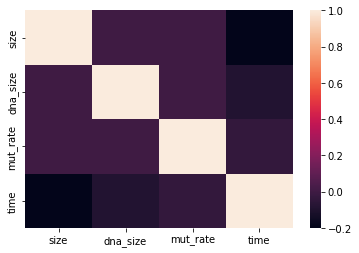

In [15]:
sns.heatmap(data_1.corr(), annot=True)

## Improvement 2
To further improve our previous code, we will try to get rid of the DNA looping problem. As the methods that read the DNA (eg. finding promoters, shine_dal..) are called much more often than those that modify it, it can be worth it to store the DNA in a more convenient manner. 
Instead of initializing this copy every single time, we create a new method called update_loop which allocates an array thrice the size of the DNA (three sequential copies). This way we can read both ends of the DNA by reading the middle copy of DNA. This copy has to be updated whenever DNA is updated but these cases are less frequent. (maybe could be mitigated by making an array of pointers to the other array).

# Data Vizualisation

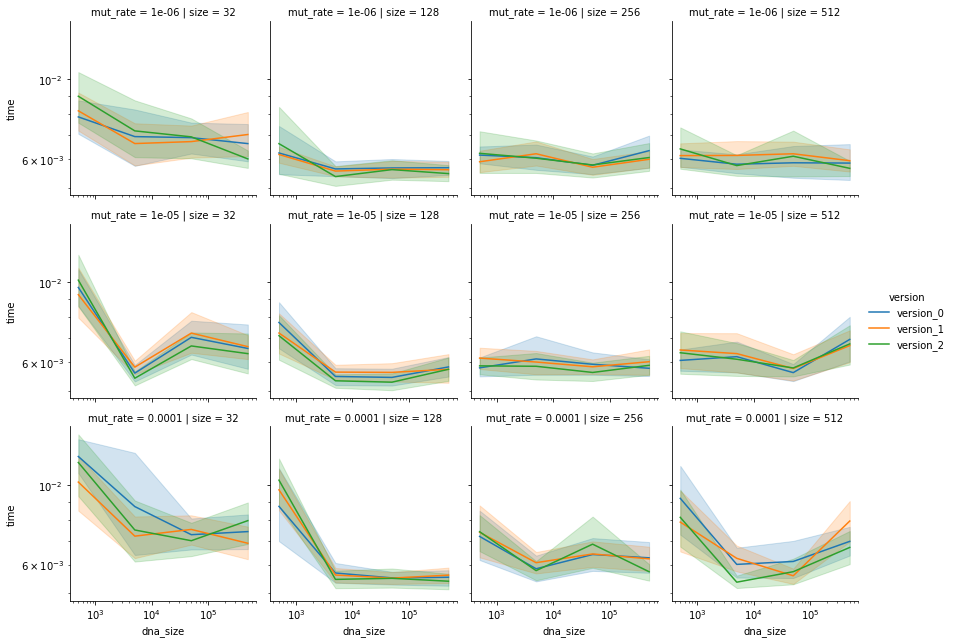

In [ ]:
sea = sns.FacetGrid(data, col = "size", row='mut_rate', hue = "version" )
sea.map(sns.lineplot, "dna_size", "time").set(yscale='log').set(xscale='log')
sea.add_legend()

Results are pretty similar due to the intel compiler's ability to optimize certain bits of code pretty effectively. Even though we divided the functions with the most self_time's execution by two or three, they represent at most a couple of percent combined.